The algorithm stopped because of reaching max iterations. Error at the end was 6.124462612225728.
The algorithm stopped because of reaching max iterations. Error at the end was 6.215862611317608.
The algorithm stopped because of reaching max iterations. Error at the end was 6.309167814564894.


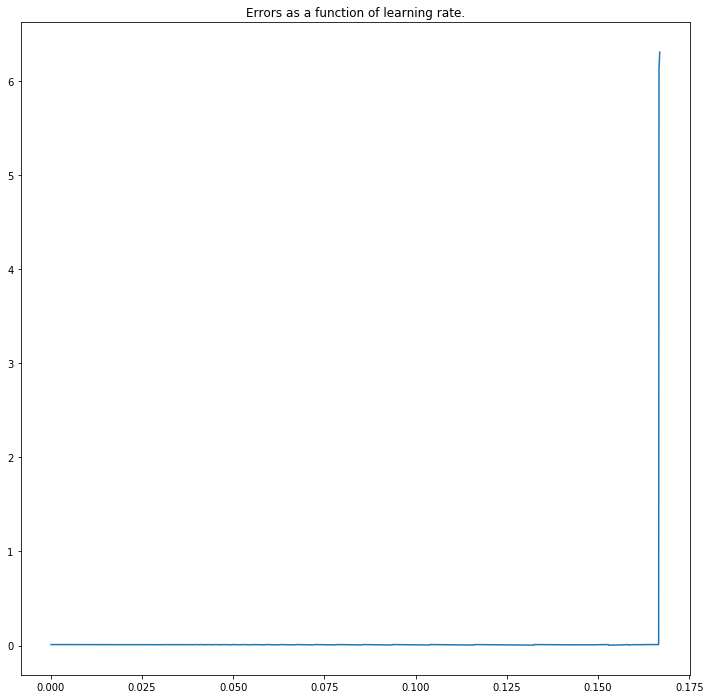

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seven_stations import calc_seven_stations
from graph_denoising import graph_denoising, graph_measures
np.set_printoptions(precision=2)

##### determinig the W_d.
filename_info = 'C:/MyTemp/ECMI_Data/dt/AlpArray/METRICS/2016366_local_pair_dist.txt'

distances = np.zeros((7,7))
# print(distances)
file = open(filename_info)
names = ["FR.CALF.00.HHZ",
         "FR.EILF.00.HHZ",
         "FR.ESCA.01.HHZ",
         "FR.MON.00.HHZ",
         "FR.MVIF.00.HHZ",
         "FR.PRIMA.00.HHZ",
         "FR.SAOF.00.HHZ"]
i = 0
for line in file:
    line_split = line.split(" ")
    if line_split[0] in names and line_split[1] in names:
        distances[names.index(line_split[0]), names.index(line_split[1])] = line_split[2]
        distances[names.index(line_split[1]), names.index(line_split[0])] = line_split[2]
        i = i+1
file.close()
# print(distances)
for i in range(7):
    distances[i,i] = np.nan
one_by_r_distances = 1/distances
# print(one_by_r_distances)
max_one_by_r = np.nanmax(one_by_r_distances)
min_one_by_r = np.nanmin(one_by_r_distances)
# print(max_one_by_r)
normalized_one = one_by_r_distances /max_one_by_r
normalized_one = np.nan_to_num(normalized_one, 0)
normalized_zero_to_one = (one_by_r_distances - min_one_by_r) / (max_one_by_r - min_one_by_r)
normalized_zero_to_one = np.nan_to_num(normalized_zero_to_one, 0)
W_d = normalized_zero_to_one
#####

#### read W_t
array = pd.read_csv("C:/MyTemp/ECMI_Data/dt/AlpArray/day_1/dt_day1.csv", delimiter=";").values[:,1].astype(np.float32)
# array = np.array
result = np.zeros((7,7))
#result[0, 1:7] = array[0:6]
#result[1, 0:1] = array[6]
#result[1, 2:7] = array[7:11]
#result[2, 0:2] = array[11:13]
#result[2, 3:7] = array[13:16]

i = 0
j = 0
for t in range(len(array)):
    if j == i:
        j = j + 1
    #print("t= " + str(t))
    #print(array[t])
    result[i, j] = array[t]
    result[j, i] = array[t]
    # print(t)
    #print("i = " + str(i))
    #print("j = " + str(j))
    if j < 6:
        j = j + 1
    else:
        j = i + 1
        i = i + 1
W_t = result

####

# W_t = np.ones((7,7)) # time delay matrix
# W_d = np.array([[0,0.4],[0.8,0.2]]) # distance matrix
estimates = graph_measures(W_d) #estimates
epsilon = 0.01 # This should be quite small
# learning_rate = 0.001 # I have no idea what this should be, we have to try different values

learning_rates = [0.0001*i for i in range(1,1670)]
results = [graph_denoising(W_t, estimates, epsilon, learning_rate=i, max_iterations=100000)for i in learning_rates] # ready to run when we get the matrices.
results_W = np.array([results[i][0] for i in range(0,1669)])
results_t = np.array([results[i][1] for i in range(0,1669)])
results_E = np.array([results[i][2] for i in range(0,1669)])

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_E)
plt.title("Errors as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()
# W_05, t_05 = graph_denoising(W_t, estimates, epsilon, learning_rate=0.05, max_iterations=1000000)
# W_1, _t_1 = graph_denoising(W_t, estimates, epsilon, learning_rate=0.01, max_iterations=1000)
# W_2, _t_2 = graph_denoising(W_t, estimates, epsilon, learning_rate=0.001, max_iterations=10000)


# print(W == W_1)
# print(W==W_2)
# print(W_1==W_2)

#print(W_t)
#print(W)


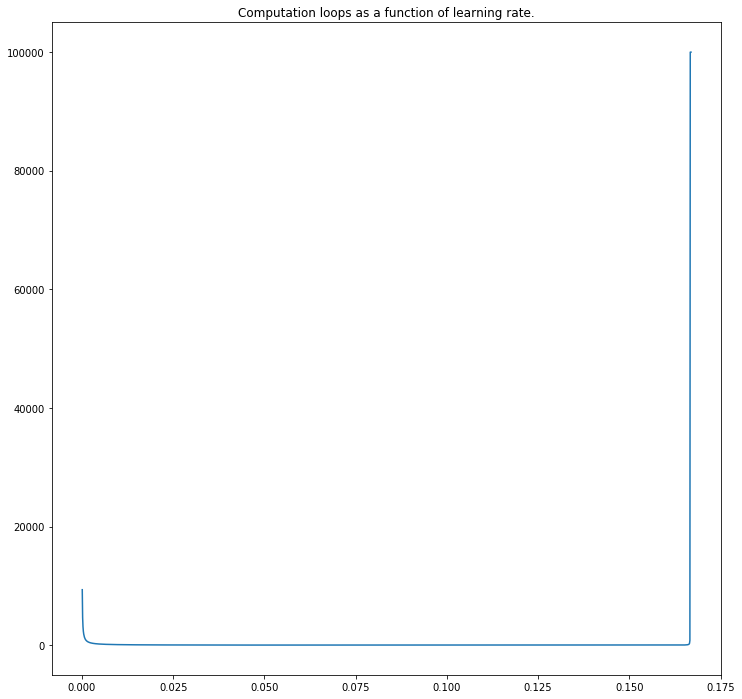

In [40]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_t)
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


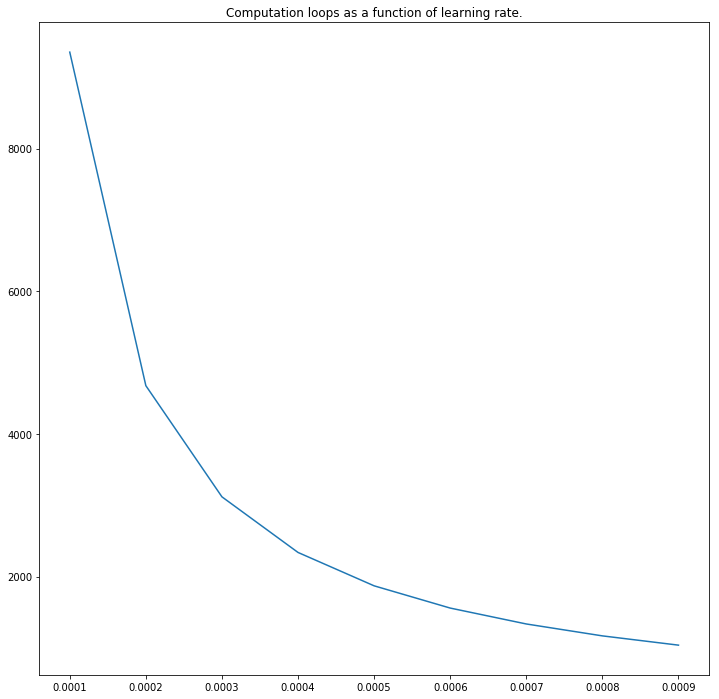

In [41]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates[0:9], results_t[0:9])
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


In [42]:
results_W[np.argmin(results_E)] #Denoised

array([[0.  , 0.34, 0.32, 0.16, 0.3 , 0.18, 0.  ],
       [0.34, 0.  , 0.57, 0.4 , 0.06, 0.42, 0.  ],
       [0.32, 0.57, 0.  , 0.38, 0.6 , 0.4 , 0.38],
       [0.16, 0.4 , 0.38, 0.  , 0.29, 1.  , 0.16],
       [0.3 , 0.06, 0.6 , 0.29, 0.  , 0.32, 0.24],
       [0.18, 0.42, 0.4 , 1.  , 0.32, 0.  , 0.19],
       [0.  , 0.  , 0.38, 0.16, 0.24, 0.19, 0.  ]])

In [43]:
W_t #Noisy one

array([[0.  , 0.81, 0.81, 0.  , 0.87, 0.  , 0.58],
       [0.81, 0.  , 0.82, 0.  , 0.39, 0.  , 0.31],
       [0.81, 0.82, 0.  , 0.  , 0.95, 0.  , 0.87],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.87, 0.39, 0.95, 0.  , 0.  , 0.  , 0.82],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.58, 0.31, 0.87, 0.  , 0.82, 0.  , 0.  ]])

In [44]:
np.argmin(results_E)

1528

In [45]:
if the_smallest_error_so_far >= np.min(results_E):
    the_best_learning_rate_so_far = learning_rates[np.argmin(results_E)]
    the_smallest_error_so_far = np.min(results_E)

In [46]:
the_smallest_error_so_far

0.003795227179658078

In [47]:
the_best_learning_rate_so_far

0.1529